# Analiza svjetskih trendova očekivanog životnog vijeka i faktora koji na njih utječu

## Uvod
U ovom eseju proučavamo, koristeći WHO-ove javno dostupne izvore podataka, kako se procjena očekivanog životnog vijeka mijenjala u raznim državama svijeta tijekom nedavne povijesti te pokušavamo identificirati razne paralelne faktore (poput trenda rasta BMI-ja, utjecaja nekih bolesti itd.) koji po mogućnosti sputavaju značajnije povećanje svjetskog prosjeka očekivanog životnog vijeka.
Također ćemo se posebno osvrnuti na lokalni trend u Hrvatskoj i pokušati ga korelirati s nekim drugim trendovima za koje postoje pouzdani podaci.

### O WHO-ovom repozitoriju podataka
Svjetska zdravstvena organizacija (WHO) održava **Global Health Observatory** (GHO) portal daje pristup raznim statistikama vezanim za zdravlje 194 zemalja članica WHO-a. Pritom je moguć uvid u preko tisuću indikatora za koje se smatraju da najviše utječu na zdravlje diljem svijeta te da se mogu razumno koristiti u komparativne svrhe s povijesnim podacima. Ti indikatori uključuju utjecaj zaraznih bolesti, kvalitetu zdravstvenih sustava, čistoću okoliša i zraka, udio nasilnih zločina itd.

# Analiza globalnih trendova zdravlja

Prvo implementiramo neke pomoćne funkcije.

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib as plt
import pathlib
import os.path
import glob
from urllib.request import urlopen, Request

def cacheirane_datoteke(ext):
    return {os.path.basename(abspath) for abspath in glob.glob("./*." + ext)}


def skini_i_cacheiraj(url: str, ext="xml"):
    datoteka = url.split('/')[-1].split('?')[0] + '.' + ext
    if datoteka not in cacheirane_datoteke(ext):
        zahtjev = Request(url, headers={'User-Agent': 'Mozilla/5.0'}) # moramo se pretvarati da smo browser kako bi nam WHO dopustio pristup
        with urlopen(zahtjev) as konekcija:
            pathlib.Path(datoteka).write_bytes(konekcija.read())
        
    return datoteka
    
def nacrtaj(df: pd.DataFrame, y_naslov=None, vrijednosti="Display"): #TODO: testiraj sve ovo!!
    min_godina = df["YEAR"].min()
    max_godina = df["YEAR"].max()
    if "YEAR" not in df.index:
        df.set_index("YEAR", inplace=True)

    df[vrijednosti].sort_index().drop_duplicates().plot(xlabel="Godina", ylabel=y_naslov,
                                                        xticks=range(min_godina, max_godina+1, 4))
    
def filtriraj(df: pd.DataFrame, filtri: dict):
    tmp = df.copy()
    for filtar, vrijednost in filtri.items():
        tmp &= (df[filtar] == vrijednost) #TODO: testirati za situaciju kada je neki filtar None
    
    return df.loc[tmp]
    #min_godina = df.loc[tmp, "YEAR"].min()
    #max_godina = df.loc[tmp, "YEAR"].max()
    #df.set_index("YEAR", inplace=True)
    #df.loc[tmp, "Display"].sort_values().drop_duplicates().plot(xlabel="Godina", ylabel=y_naslov, xticks=range(min_godina, max_godina+1, 4))
    
def nacrtaj_kombinirani_indikator_kroz_godine(df: pd.DataFrame, filtri: dict, indikator: str, indikator_hr: str,
                                              kombinirati_po: str, za_obrisati=None, indikator_ključ="GHO",
                                              y_naslov=None, vrijednosti="Display"):
    if za_obrisati is not None: 
        kombinirano = (df.drop(df[df[ključ] == vrijednost].index) for ključ, vrijednost in za_obrisati)
    else:
        kombinirano = df.copy()
    
    kombinirano = filtriraj(kombinirano, filtri)
    kombinirano.set_index(["YEAR", kombinirati_po], inplace=True)
    kombinirano = kombinirano.loc[~kombinirano.index.duplicated(), vrijednosti].unstack(kombinirati_po)
    nacrtaj(kombinirano, y_naslov)
    
def nacrtaj_indikator_kroz_godine(df: pd.DataFrame, država: str, indikator: str, indikator_hr: str, indikator_ključ="GHO", spol="Both sexes"):
    tmp = df.loc[(df[indikator_ključ] == indikator) & (df["COUNTRY"] == država) & (df["SEX"] == spol), "YEAR"]
    min_godina = tmp.min()
    max_godina = tmp.max()
    df2 = df.set_index("YEAR")
    df2.loc[(df2[indikator_ključ] == indikator) & (df2["COUNTRY"] == država) & (df2["SEX"] == spol),
            "Display"].sort_values().drop_duplicates().plot(xlabel="Godina", ylabel=indikator_hr, xticks=range(min_godina, max_godina+1, 4))
    
def prevedi_na_hrvatski(df: pd.DataFrame):
    """ Prevodi nazive pojedinih bitnih stupaca na hrvatski, radi prikazivanja na grafovima. """
    df.rename(columns={"SEX": "Spol"}, inplace=True) 
    #df.loc[df[df["Spol"] == "Male"], "Spol"] = "Muški"
    #df.loc[df[df["Spol"] == "Female"], "Spol"] = "Ženski"
    #df.loc[df[df["Spol"] == "Both sexes"], "Spol"] = "Oba spola"
    df.replace(to_replace={"Male": "Muški", "Female": "Ženski", "Both sexes": "Oba spola"}, inplace=True)

<AxesSubplot:xlabel='YEAR'>

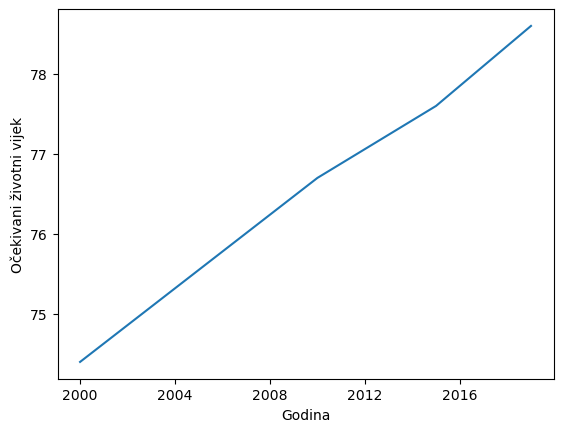

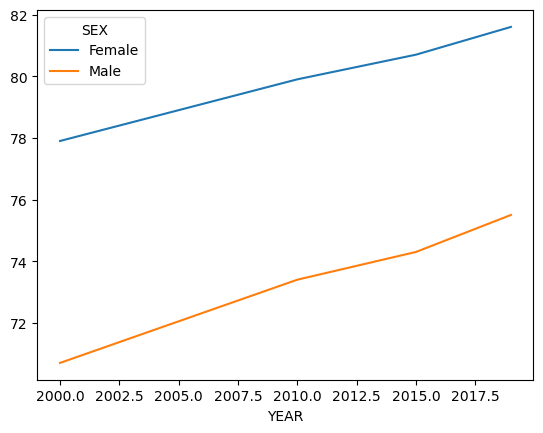

In [14]:
data = skini_i_cacheiraj("https://apps.who.int/gho/athena/api/GHO/WHOSIS_000001?profile=simple")
df = pd.read_xml(data)
nacrtaj_indikator_kroz_godine(df, "Croatia", "Life expectancy at birth (years)", "Očekivani životni vijek")

spolovi = df.drop(df[df["SEX"] == "Both sexes"].index) # riješimo se agregata po spolovima jer ih sada želimo direktno usporediti
spolovi.set_index(["YEAR", "SEX"], inplace=True)
spolovi = spolovi.loc[(spolovi["COUNTRY"] == "Croatia") & (spolovi["GHO"] == "Life expectancy at birth (years)") 
                     ]
spolovi = spolovi.loc[~spolovi.index.duplicated(), "Display"].unstack("SEX")

spolovi.head()
spolovi.sort_index().plot()

#TODO: vidi kako bi mogao iskoristiti isin()

#nacrtaj_indikator_kroz_godine(spolovi, "Croatia", "Life expectancy at birth (years)", "Očekivani životni vijek", None, None)

# Analiza lokalnih trendova zdravlja

U ovoj sekciji se fokusiramo na detaljniju analizu faktora koji utječu na zdravlje europskih zemalja tijekom vremena, i to specifično članica Europske unije. Ovdje također spada i Hrvatska, pa ćemo ostaviti posljednji dio ovog rada za detaljniju usporedbu naših trendova s onim ostalih zemalja članica te ćemo dati neke predikcije za skoriju budućnost.

TODO: za ove podatke koristiti who-euro bazu i sljedeće indikatore (uglavnom iz https://dw.euro.who.int/api/v3/data_sets/HFA a za ono što nije tamo uvije pogledaj referentnu listu na https://dw.euro.who.int/ i najvjerojatnije je pod Health-enhancing physical activity, Environment and Health ili Child and Adolescent Health):
* Life expectancy at birth
* Population aged 0-14
* Population aged 65+
* Number of live births
* Total fertility rate
* Number of all hospital discharges
* Private households' out-of-pocket payments on health as proportion of total health expenditure
* Total health expenditure as proportion of GDP
* Acute (short-stay) hospitals per 100 000
* Acute care hospital beds per 100 000
* Associate professional nurses, practising, total
* Associate professional nursing graduates, total
* Beds in publicly owned hospitals, total
* Caring personnel, practising or closest concept, total
* Computed Tomography Scanners, total
* Dentists (PP) per 100 000
* Dentists graduates, total
* Digital subtraction angiography units, total 	HRes
* Gamma cameras, total 	HRes
* General hospitals, total 	HRes
* General paediatricians, total HRes
* General practitioners (PP) per 100 000 	HFA
* Magnetic Resonance Imaging Units, total 	HRes
* Mammographs, total 	HRes
* Positron Emission Tomography scanners , total 	HRes
* Proportion of physicians, both sexes, 65 years old or older 	HRes
* Proportion of physicians, both sexes, younger than 35 years 	HRes
* Psychiatric hospital beds per 100 000 	HFA
* Psychiatrists, total 	 HRes
* Radiation therapy equipment, total 	HRes
* Abortions per 1000 live births 	HFA
* Maternal deaths, according to clinical data 	HFA
* Proportion of births attended by skilled health personnel 	HFA
* Proportion of infants breastfed at age 3 months 	HFA
* Proportion of infants vaccinated against tetanus 	HFA
* Proportion of infants vaccinated against tuberculosis 	HFA
* Proportion of live births weighing 2500 g or more 	HFA
* Microbiological foodborne diseases per 100 000 	HFA
* Number of people injured due to work-related accidents 	HFA
* Number of salmonellosis cases 	HFA
* Proportion of population with access to sewage system, septic tank or other hygienic means of sewage disposal 	HFA
* Proportion of population with homes connected to water supply system 	HFA
* Age-standardized prevalence of current tobacco smoking among people aged 15 years and over (WHO estimates) 	HFA
* Age-standardized prevalence of overweight (defined as BMI = 25 kg/m2) in people aged 18 years and over (WHO estimates) 	HFA
* Average amount of fruits and vegetables available per person per year (kg) 	HFA
* Average number of calories available per person per day (kcal) 	HFA
* Fat available per person per day (g) 	HFA
* First admissions to drug treatment centres per 100 000 	HFA
* Number cigarettes consumed per person per year 	HFA
* Number of people killed or injured in road traffic accidents 	HFA
* Number of road traffic accidents involving alcohol 	HFA
* Protein available per person per day (g) 	HFA
* Absenteeism from work due to illness, days per employee per year 	HFA
* All cases of mental disorders at year's end 	HFA
* Incidence of cancer 	HFA
* Number of all cases of diabetes mellitus at year's end 	HFA
* SDR, Accidents 	MDB
* SDR, All causes 	MDB
* SDR, Chronic lower respiratory diseases 	MDB
* SDR, diabetes, all ages 	HFA
* SDR, diseases of digestive system, all ages 	HFA
* SDR, Diseases of nervous system and sense organs 	MDB
* SDR, Diseases of the circulatory system 	MDB
* SDR, Diseases of the respiratory system 	MDB
* SDR, Diseases of the digestive system 	MDB
* SDR, endocrine, nutritional and metabolic diseases, all ages 	HFA
* SDR, homicide and intentional injury, all ages 	HFA
* SDR, infectious and parasitic diseases, all ages 	HFA
* SDR, ischaemic heart disease, all ages 	HFA
* SDR, mental disorders, diseases of nervous system and sense organs, all ages 	HFA
* SDR, motor vehicle traffic accidents, all ages 	HFA
* SDR, suicide and self-inflicted injury, all ages 	HFA
* 


## Analiza hrvatskih trendova zdravlja i usporedba s ostalim članicama EU

# Zaključak